# Lecture 8 — Bayesian Statistical Inference: I

[Open this notebook in Google Colab](https://colab.research.google.com/github/daanmeerburg/Statistics_meerburg_2026//blob/main/Lectures/Lecture_08_PDM.ipynb)


**Lecturer:** P. D. Meerburg 

*Heavily based on materials by Davide Gerosa (astroML, 2022) and collaborators. See [here](https://github.com/dgerosa/astrostatistics_bicocca_2023/blob/main/README.md) for credits.*

##### Reading:

- [Ivezic textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 5.
- [Jake VanderPlas's blog "Frequentism and Bayesianism: A Practical Introduction"](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)
- [Jake VanderPlas: "Frequentism and Bayesianism: A Python-driven Primer"](https://arxiv.org/abs/1411.5018)
- [Hogg, Bovy and Lang: "Data analysis recipes: Fitting a model to data"](https://arxiv.org/abs/1008.4686)



##### For those who want to dive deep:

- [Jake VanderPlas's workshop "Bayesian Astronomy"](https://github.com/jakevdp/BayesianAstronomy)
- [D. Sivia and J. Skilling: "Data Analysis: A Bayesian Tutorial"](https://www.amazon.com/Data-Analysis-Bayesian-Devinderjit-Sivia/dp/0198568320)
- [E.T. Jaynes: "Probability Theory: The Logic of Science"](http://bayes.wustl.edu/etj/prob/book.pdf)
- [E.T. Jaynes: "Confidence Intervals vs. Bayesian intervals"](http://bayes.wustl.edu/etj/articles/confidence.pdf)
- [This great explanation of confidence levels versus credible regions on Stackexchange](https://stats.stackexchange.com/questions/2272/whats-the-difference-between-a-confidence-interval-and-a-credible-interval/2287#2287)



___

>## From "Bayes Rule" To "Bayesian Inference" <a class="anchor" id="one"></a>

We had that 

$$p(x,y) = p(x|y)p(y) = p(y|x)p(x).$$

We also used the notation for intersection ($p$ that both $A$ **and** $B$ will happen) 

$$p(A \cap B) \equiv p(A,B) = p(A|B)p(B) = p(B|A)p(A).$$

We can define the **marginal probability** as

$$p(x) = \int p(x,y)dy,$$

where **marginal means essentially projecting on to one axis**, and **conditional means taking a slice at a fixed value of one axis**.

We can re-write this as

$$p(x) = \int p(x|y)p(y) dy.$$

Since $$p(x|y)p(y) = p(y|x)p(x),$$ 

we can write that

$$p(y|x) = \frac{p(x|y)p(y)}{p(x)} = \frac{p(x|y)p(y)}{\int p(x|y)p(y) dy},$$

which in words says that

> the (conditional) probability of $y$ given $x$ is just the (conditional) probability of $x$ given $y$ times the (marginal) probability of $y$ divided by the (marginal) probability of $x$, where the latter is just the integral of the numerator.

This is **Bayes' rule**, which itself is not at all controversial, though its application can be as we'll discuss in detail. 

And by the way, what are the units of the various terms in the above expression?

### Recall Maximum Likelihood Estimation (MLE) applied to a Heteroscedastic Gaussian

Assume $N$ measurements, $\{x_i\}$, where the uncertainty for each measurement is Gaussian with
a known $\sigma_i$. The likelihood of one measurement is 

$$L \equiv p(x_i|\mu,\sigma_i) = \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma_i^2}\right),$$


and therefore the likelihood of all N measurements is

$$L \equiv p(\{x_i\}|\mu,\sigma_i) = \prod_{i=1}^N \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma_i^2}\right).$$

In [1]:
# Execute this cell
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
np.random.seed(42)

Let's draw a homoscedastic sample of $\{x_i\}$ from a Gaussian and see what happens with $L$. First generate a sample of $N$ points drawn from $\mathcal{N}(\mu,\sigma)$.

In [2]:
sampleSize = 3 # number of samples to draw
mu = 0.1 # mean of the normal distribution
sigma = 0.2 # standard deviation of the normal distribution
sample = norm(mu, sigma).rvs(sampleSize) # draw random samples from the normal distribution
print(sample)

[0.19934283 0.07234714 0.22953771]


As we did in the MLE lectures, let's now compute probabilities for each point centered at the measured value across a grid, and multiply the probabilities together to find the likelihood for the dataset.

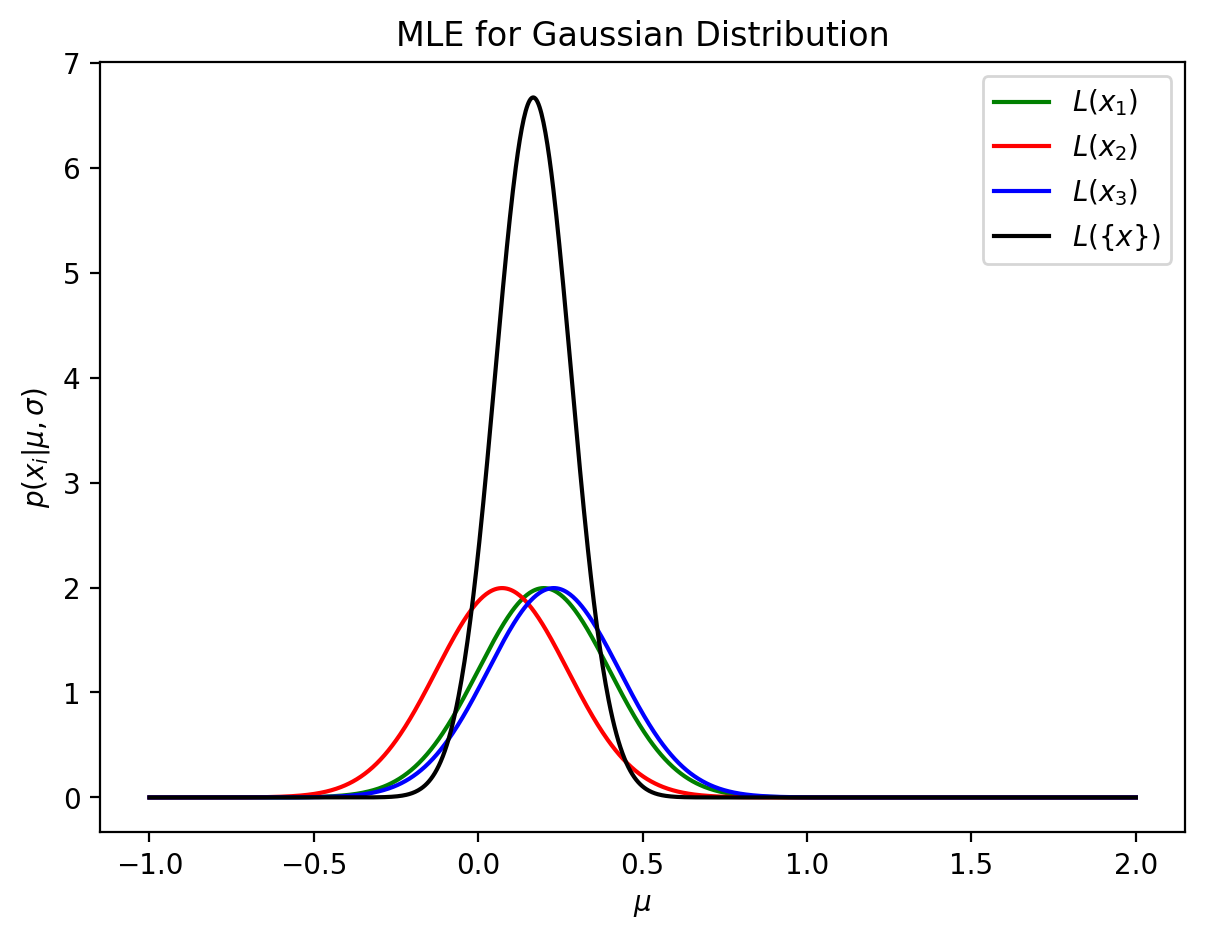

In [3]:
muGrid = np.linspace(-1,2,1000) # grid of mu values

L1 = norm(sample[0], sigma).pdf(muGrid) # likelihoods for each sample
L2 = norm(sample[1], sigma).pdf(muGrid) 
L3 = norm(sample[2], sigma).pdf(muGrid) 
L = L1 * L2 * L3 # combined likelihood

# plot
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(muGrid, L1, ls='-', c='green', 
         label=r'$L(x_1)$')
plt.plot(muGrid, L2, ls='-', c='red', 
         label=r'$L(x_2)$')
plt.plot(muGrid, L3, ls='-', c='blue', 
         label=r'$L(x_3)$')
plt.plot(muGrid, L, ls='-', c='black', 
         label=r'$L(\{x\})$')

#plt.xlim(0.2, 1.8)
#plt.ylim(0, 8.0)
plt.xlabel('$\mu$')
plt.ylabel(r'$p(x_i|\mu,\sigma)$')
plt.title('MLE for Gaussian Distribution')
plt.legend()
plt.show() 

But suppose if $\mu$ is the mass of a galazy. Surely that cannot be negative.  That's prior information! We can fold this directly into the likelihood:

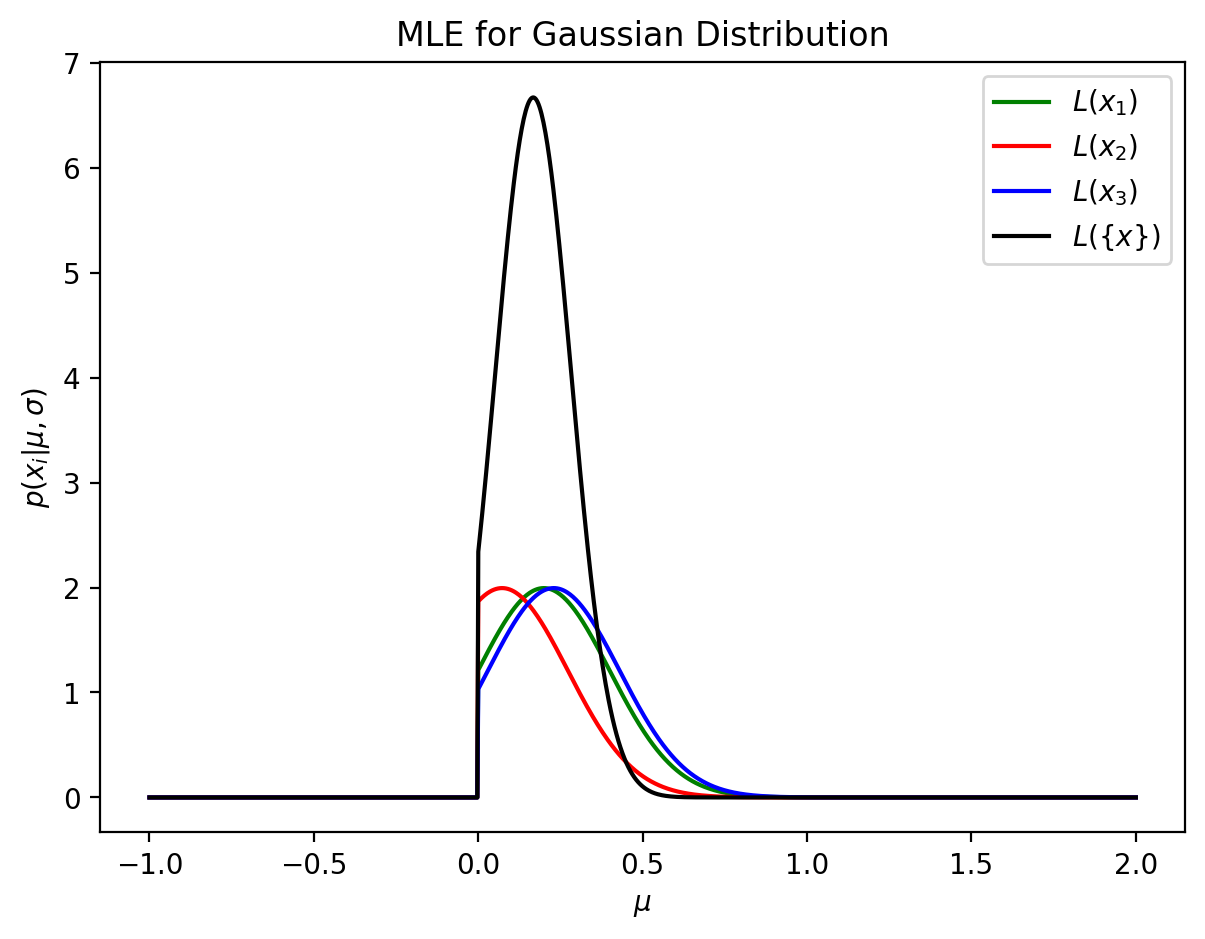

In [4]:
muMin = 0 # minimum mu value due to prior
L1[muGrid < muMin] = 0 # apply prior: mu >= 0
L2[muGrid < muMin] = 0
L3[muGrid < muMin] = 0
L = L1 * L2 * L3 # combined likelihood with prior

# plot
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(muGrid, L1, ls='-', c='green', label=r'$L(x_1)$')
plt.plot(muGrid, L2, ls='-', c='red', label=r'$L(x_2)$')
plt.plot(muGrid, L3, ls='-', c='blue', label=r'$L(x_3)$')
plt.plot(muGrid, L, ls='-', c='black', label=r'$L(\{x\})$')

#plt.xlim(0.2, 1.8)
#plt.ylim(0, 8.0)
plt.xlabel('$\mu$')
plt.ylabel(r'$p(x_i|\mu,\sigma)$')
plt.title('MLE for Gaussian Distribution')
plt.legend()
plt.show() 

Clearly the *maximum is unchanged in this trivial example*, but the distribution is truncated leading to very different uncertainty estimates than what one would naively get by assuming that all $\mu$ values are equally likely.

### The Essence of the Bayesian Method 

- The basic premise of the Bayesian method is that probability statements are not limited to data, but can be made for model parameters and models themselves. 
- Inferences are made by producing  probability density functions (pdfs); most notably, **model parameters are treated as random variables**.
- These **pdfs represent our "belief spread" in what the model parameters are**. They have nothing to do with outcomes of repeated experiments (although the shape of resulting distributions can often coincide).


### Brief History 

- The **Reverend Thomas Bayes (1702–1761)** was an English amateur mathematician who wrote a manuscript 
on how to combine an initial belief with new data to arrive at an improved belief. 
- The manuscript 
was published posthumously in 1763 and gave rise to the name Bayesian statistics. 
- **Laplace** rediscovered the Bayesian approach a decade after it was originally published, and greatly clarified some principles.  
- However, Bayesian statistics did not find its ways into mainstream science until well into the 20th century, and widespread usage has been hindered until the 1990s with the advent of cheap computing that can map out the Bayesian probability distributions.

![](https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif?1613667187659)

### Bayesian Statistical Inference

Up to now we have been computing the **likelihood** $p(D\,|\,M)$.  In Bayesian inference, we instead evaluate the **posterior probability** taking into account **prior** information.

Recall that Bayes' Rule is:

$$p(M\,|\,D) = \frac{p(D\,|\,M)\,p(M)}{p(D)},$$

where $D$ is for data and $M$ is for model. Or in words,

$${\rm Posterior \,\, Probability} = \frac{{\rm Likelihood}\times{\rm Prior}}{{\rm Evidence}}.$$

If we explicitly recognize prior information, $I$, and the model parameters, $\theta$, then we can write:

$$p(M,\theta \,|\,D,I) = \frac{p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)}{p(D\,|\,I)},$$

where we will omit the explict dependence on $\theta$ by writing $M$ instead of $M,\theta$ where appropriate.  However, as the prior can be expanded to 

$$p(M,\theta\,|\,I) = p(\theta\,|\,M,I)\,p(M\,|\,I),$$

it will still appear in the term $p(\theta\,|\,M,I)$.

**NOTE** 

We don't often care about **the evidence $p(D\,|\,I)$** because it does not depend on model parameters. We usually set it to $1$ for parameter estimation. **BUT** it's at the heart of Bayesian model selection (which we'll look at in the future) since it gives us a way of ranking different model descriptions of the data. This will allow model selection that is not a simple function of the number of degrees of freedom and $\chi$, such as those discussed earlier (e.g. AIC, BIC) 

**The Bayesian Statistical Inference process** is then
1. formulate the likelihood, $p(D\,|\,M,\theta,I)$
2. chose a prior, $p(M,\theta\,|\,I)$, which incorporates *other information beyond the data in $D$*
3. determine the posterior pdf, $p(M,\theta \,|\,D,I)$
4. explore/map the posterior distribution $p(M,\theta \,|\,D,I)$ 
5. extract some summary statistics and quantify the uncertainty of the model parameter estimates
6. perform model selection to find the most apt description of the data

Compare this bullet points with the MLE workflow from a few lectures ago: what's similar? And what's different?

Before applying this expression, we need to discuss how to choose priors.

>## Bayesian priors: What Are They & How Do I Choose Them? <a class="anchor" id="two"></a>

Priors can be **informative** or **uninformative**.  As it sounds, informative priors are based on existing information (including previously obtained data, but not the data considered right now) that might be available.  Uninformative priors can be thought of as "default" priors, i.e., what your prior is when you never used
any data, e.g, a "flat" prior like $p(\theta|M,I) \propto {\rm C}$.

Detailed discussion can be found in Section 5.2 in the textbook. In general, we want our inferences to be ***data dominated*** rather than prior dominated, so we try to use ***weakly-informative priors***. There are three
main principles used to choose a prior: 


### (i) The Principle of Indifference

Essentially this means adopting a uniform prior, though you have to be a bit careful.  Saying that an asteroid is equally likely to hit anywhere on the Earth is not the same as saying that all latitudes of impact are equally likely.  

Assuming $1/6$ for a six-side die, or $1/2$ for heads and tails of a fair coin, would be an example of indifference.

### (ii) The Principle of Invariance (or Consistency)

This applies to location and scale invariance.  

**Location invariance** suggests a uniform prior, within the accepted bounds: $p(\theta|I) \propto 1/(\theta_{max}-\theta_{min})$ for $\theta_{min} \le \theta \le \theta_{max}$. 

**Scale invariance** gives us priors that look like $p(\theta|I) \propto 1/\theta$, which implies a uniform
prior for $\ln(\theta)$, i.e. a prior that gives equal weight over many orders of magnitude. 

### (iii) The Principle of Maximum Entropy

We will not discuss it here - for more details, see Section 5.2.2 in the textbook.
 
It is often true that Bayesian analysis and traditional MLE are essentially equivalent.  
However, in some cases, considering the priors can have significant consequences, as
we will see later. 

We will skip examples of very steep priors and their consequences called in astronomy
literature **Eddington-Malmquist** and **Lutz-Kelker** biases (if you are interested, see Chapter 5 in the textbook as well as [here](https://en.wikipedia.org/wiki/Lutz%E2%80%93Kelker_bias)). 



### Conjugate Priors

In special combinations of priors and likelihood functions, the resulting posterior probability distribution is from the same function family as the prior. These priors are called **conjugate priors** and give a convenient way for generalizing computations. There are exhaustive tables [here](https://www.wikiwand.com/en/Conjugate_prior#/Table_of_conjugate_distributions). The Eddington–Malmquist bias has an analogue in particle physics, most commonly appearing as resolution smearing and selection bias in steeply falling spectra, usually handled via unfolding, efficiency corrections, and trigger modeling.

**EXAMPLE**

If the likelihood is Gaussian and the prior function is Gaussian, then so too is the posterior distribution! So the conjugate prior for a Gaussian likelihood is Gaussian.

For data drawn from a Gaussian likelihood equal to $\mathcal{N}(\bar{x},s)$ (where $\bar{x}$ is the sample mean and $s$ is the sample standard deviation), with a prior on the underlying parameters $\mathcal{N}(\mu_0,\sigma_0)$, the posterior is $\mathcal{N}(\mu_{\rm post},\sigma_{\rm post})$, where

$$\mu_{\rm post} = \frac{\mu_0/\sigma_0^2 + \bar{x}/s^2}{1/\sigma_0^2 + 1/s^2},\quad \sigma_{\rm post} = \left( 1/\sigma_0^2 + 1/s^2 \right)^{-1/2}. $$


### Hierarchical Bayes

You will often hear the term **hierarchical Bayesian modeling**.
Despite the intimidating name, the underlying idea is simple and very natural.

So far, we have treated priors as fixed distributions:
for example, a Gaussian prior with a fixed mean and width, or a uniform prior
over some parameter range.

In **hierarchical Bayesian inference**, the parameters of the prior itself
become part of the inference problem.
These parameters are called **hyperparameters**.
They describe the *population-level distribution* from which individual events
are drawn.
Hyperparameters are assigned their own priors, called **hyperpriors**.

The result is a model with multiple layers of inference:
- parameters describing individual objects or events,
- hyperparameters describing the population,
- and priors at each level.

This is what makes the model *hierarchical*.

---

### Why does this arise naturally?

In many areas of physics, we do not observe just one system,
but an **ensemble** of related systems.
Each observation gives noisy information about an individual object,
but collectively the data inform us about the underlying population.

Hierarchical Bayesian modeling provides a principled way to combine these two
levels of information.

---

### Exoplanets and gravitational waves

A classic example comes from **exoplanet population studies**.
Each detected exoplanet is analyzed individually by fitting a likelihood model
to light-curve or radial-velocity data, using weakly informative priors.
However, those priors implicitly describe the underlying population of orbital
periods, radii, or eccentricities.

Once many systems are observed, we can infer not only the properties of each
planet but also the population-level distribution itself.
This idea is discussed, for example, in [Hogg, Myers & Bovy (2010), *Data analysis recipes: Fitting a model to data*](https://arxiv.org/abs/1008.4686) and applied in exoplanet population analyses such as [Foreman-Mackey et al. (2014)](https://arxiv.org/abs/1406.3020).

The same logic applies in **gravitational-wave astronomy**.
Each detected compact-binary merger is analyzed to infer masses, spins, and
orbital parameters, which requires specifying priors.
As the catalog of detections grows, we can then infer the *population*
distribution of these parameters, while accounting for selection effects.
Hierarchical Bayesian inference is now the standard framework for this problem (e.g. [Abbott et al. (2021)](https://arxiv.org/abs/2111.03634); [Vitale et al. (2020)](https://arxiv.org/abs/2007.05579)).

---

### Cosmology

Hierarchical Bayesian models arise naturally in several cosmological contexts.

In **weak gravitational lensing**, individual galaxy shape measurements are
extremely noisy.
The intrinsic shape distribution of galaxies is not known a priori and must be
modeled at the population level.
At the same time, correlations between galaxy shapes encode cosmological
information.
A fully Bayesian hierarchical framework for jointly inferring shear fields and cosmological power spectra is developed by [Heavens et al. (2016)](https://arxiv.org/abs/1602.05345).

Hierarchical inference is also widely used in **galaxy–halo modeling**.
For example, [Sonnenfeld & Leauthaud (2017)](https://arxiv.org/abs/1710.00007)  
use a hierarchical Bayesian model to infer scaling relations between galaxy
properties and dark-matter halo mass from galaxy–galaxy lensing data, while
accounting for intrinsic scatter and measurement uncertainty.

Another important cosmological application is **redshift inference**.
Galaxy redshift distributions are latent quantities that must be inferred from
noisy photometric data.
[Sánchez & Bernstein (2018)](https://arxiv.org/abs/1807.11873)  
present a hierarchical framework that combines photometry and clustering
information to infer these distributions and propagate uncertainties into
cosmological analyses.

---

### Particle physics

Hierarchical Bayesian ideas also appear in particle physics, even when analyses
are not explicitly described using this language.

In **signal searches**, event-level observables are often modeled as arising from
a mixture of signal and background processes.
The background itself is uncertain and can be described by hyperparameters that
are inferred jointly with the signal model. A concrete example of this approach is discussed in [*A frequency-calibrated Bayesian search for new particles*](https://projecteuclid.org/journals/annals-of-applied-statistics/volume-12/issue-3/A-frequency-calibrated-Bayesian-search-for-new-particles/10.1214/18-AOAS1138.pdf)  (Annals of Applied Statistics, 2018).

Hierarchical modeling also appears in **detector calibration and resolution
modeling**, where event-level likelihoods depend on nuisance parameters whose
distributions are inferred from calibration data, and in **global fits** that
combine multiple experiments with shared physics parameters and
experiment-specific uncertainties.

Although frequentist methods remain dominant in much of particle physics,
hierarchical Bayesian models provide a unified conceptual framework for handling
latent variables, nuisance parameters, and population-level uncertainty.

---

### A useful intuition

Hierarchical Bayesian inference answers two questions at once:

> *What are the properties of each system?*  
> *What is the distribution from which these systems are drawn?*

When only a few objects are observed, prior assumptions about the population
matter strongly.
As more data are collected, the population itself becomes increasingly
data-driven.

---

### A practical approximation: empirical Bayes

In some applications, hyperparameters are estimated from the data and then
treated as fixed.
This approach is known as **empirical Bayes**.

A classic and very intuitive example is shrinkage estimation in baseball batting
averages, discussed here: [Empirical Bayes and baseball statistics](http://varianceexplained.org/r/empirical_bayes_baseball/)

While not fully Bayesian, empirical Bayes often captures much of the benefit of
hierarchical modeling with reduced computational cost.

>## Bayesian credible regions <a class="anchor" id="three"></a>

In the **frequentist paradigm**, the meaning of the *confidence interval* $\mu_0 \pm \sigma_{\mu}$ is 
the interval that would contain the true $\mu$ (from which the data were drawn) in $68\%$ (or X\%) cases
of a large number of *imaginary repeated experiments* (each with a different N values of $\{x_i\}$). 

However, the meaning of the so-called ***Bayesian credible region*** is *fundamentally different*: it is the interval that contains the true $\mu$ with a probability of $68%\$ (or $X\%$), given the given dataset (our dear one and only dataset - there are no imaginary experiments in Bayesian paradigm). This credible region is the 
relevant quantity in the context of scientific measurements. 

There are several important features of a Bayesian posterior distribution:
- They represent how well we believe a parameter is constrained within a certain range
- We often quote the posterior maximum (**Maximum A Posteriori (MAP)**).
- We also often quote the posterior expectation value (i.e. mean) $\bar{\theta} = \int \theta\, p(\theta|D)d\theta$, or its median.
- ***The credible regions are not unique***. We can compute them in two different ways (visualized below)
    1. We can integrate downwards from the MAP to enclose $X\%$ ("highest probability density interval"), or
    2. We can integrate inwards from each tail by $X/2\%$ ("equal-tailed interval")


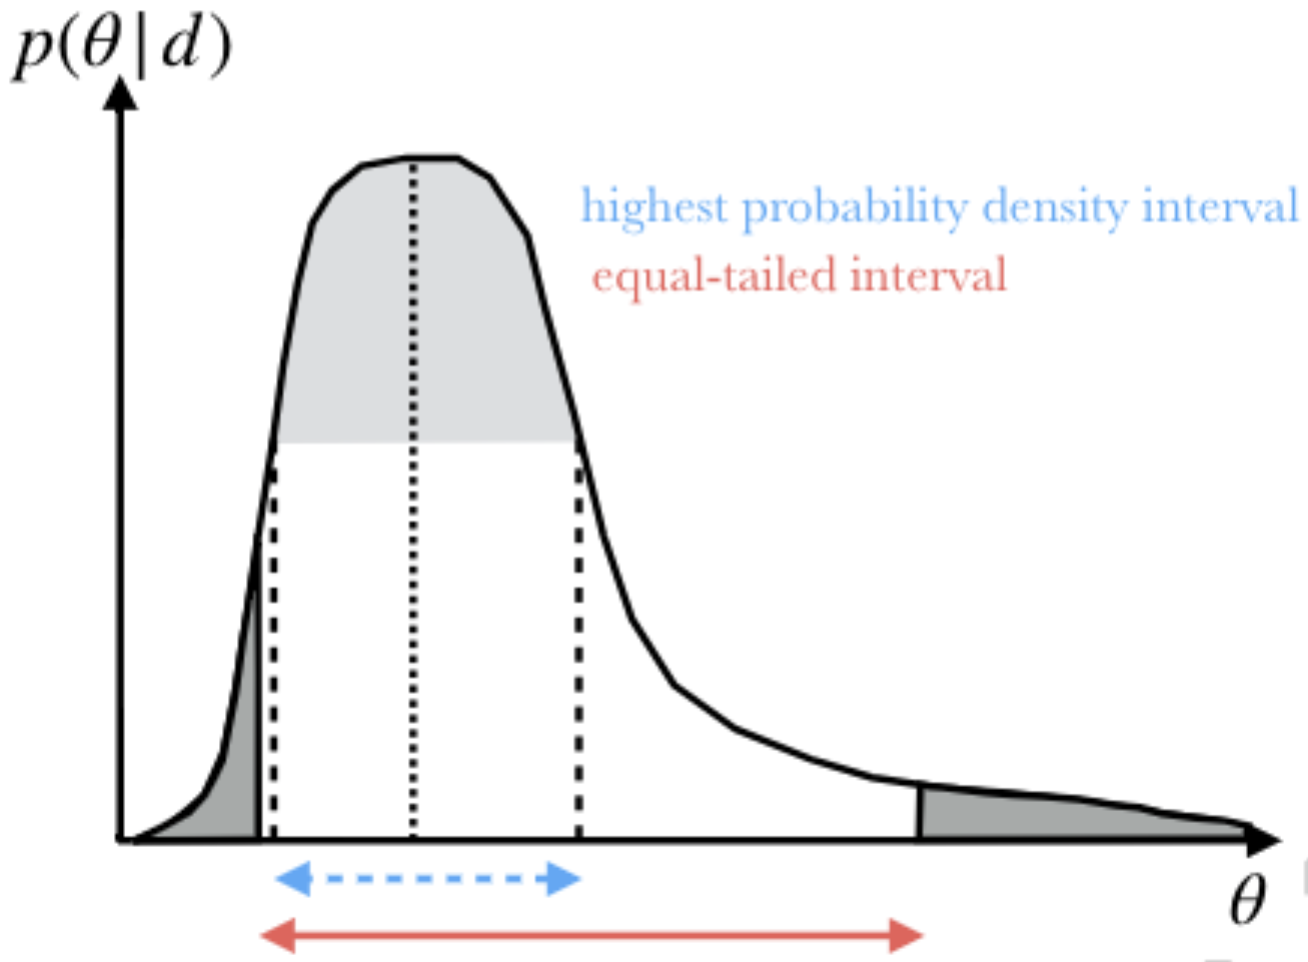

>## Simple parameter estimation examples <a class="anchor" id="four"></a>

Imagine you meet a gambler who asks you to **bet on whether a coin will come up heads or tails**.
You do not know whether the coin is fair.

Before betting, you are allowed to watch the gambler flip the coin many times
while other people make guesses.
From these observations, you want to learn something about how biased the coin is.

---

### Modeling the coin

Let us introduce a parameter

$$
\theta \equiv P(\text{heads}),
$$

the probability that a single coin flip results in heads.
If the coin is fair, $\theta = 1/2$.
If the coin is biased, $\theta \neq 1/2$.

Each coin flip is a **Bernoulli trial**:
- probability $\theta$ of heads,
- probability $1-\theta$ of tails.

---

### Repeated flips

Suppose we observe the coin flipped $n$ times and obtain:
- $h$ heads,
- $n-h$ tails.

We assume:
- each flip is independent,
- the probability $\theta$ does not change between flips.

Under these assumptions, the probability of observing *this particular outcome*
is given by the **binomial distribution**:

$$
P(h \mid \theta, n)
= \binom{n}{h}\,\theta^h (1-\theta)^{n-h}.
$$

Here:
- $\binom{n}{h}$ counts how many different sequences of flips lead to $h$ heads,
- $\theta^h$ is the probability of obtaining $h$ heads,
- $(1-\theta)^{n-h}$ is the probability of obtaining $n-h$ tails.

---

We want to calculate and plot the Bayesian posterior of the probability of drawing a head as a function of watching [5, 50, 500] coin flips.

Ok so:

* formulate the likelihood, $p(D\,|\,M,\theta,I)$
* choose a prior
* plot the posterior pdf, $p(M,\theta \,|\,D,I)$

Ideas?

Note: the full binomial distribution includes a factor $\binom{n}{h}$.
Since this factor does not depend on $\theta$, it is irrelevant when the
expression is viewed as a likelihood function and can therefore omitted below.




In [5]:
# Execute this cell for some data to use
data = np.array([
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1])

In [13]:
print("number of flips =", len(data))
print("number of tails =", np.sum(data==0))
print("number of heads =", np.sum(data==1)) #total, tails, heads

number of flips = 500
number of tails = 144
number of heads = 356


Note that the generated data set is highly biased towards "1", as in, it is not 50/50, but rather 1/4 vs 3/4, and hence the probabilty of heads is expected to be of the order of 75% for the full sample. 

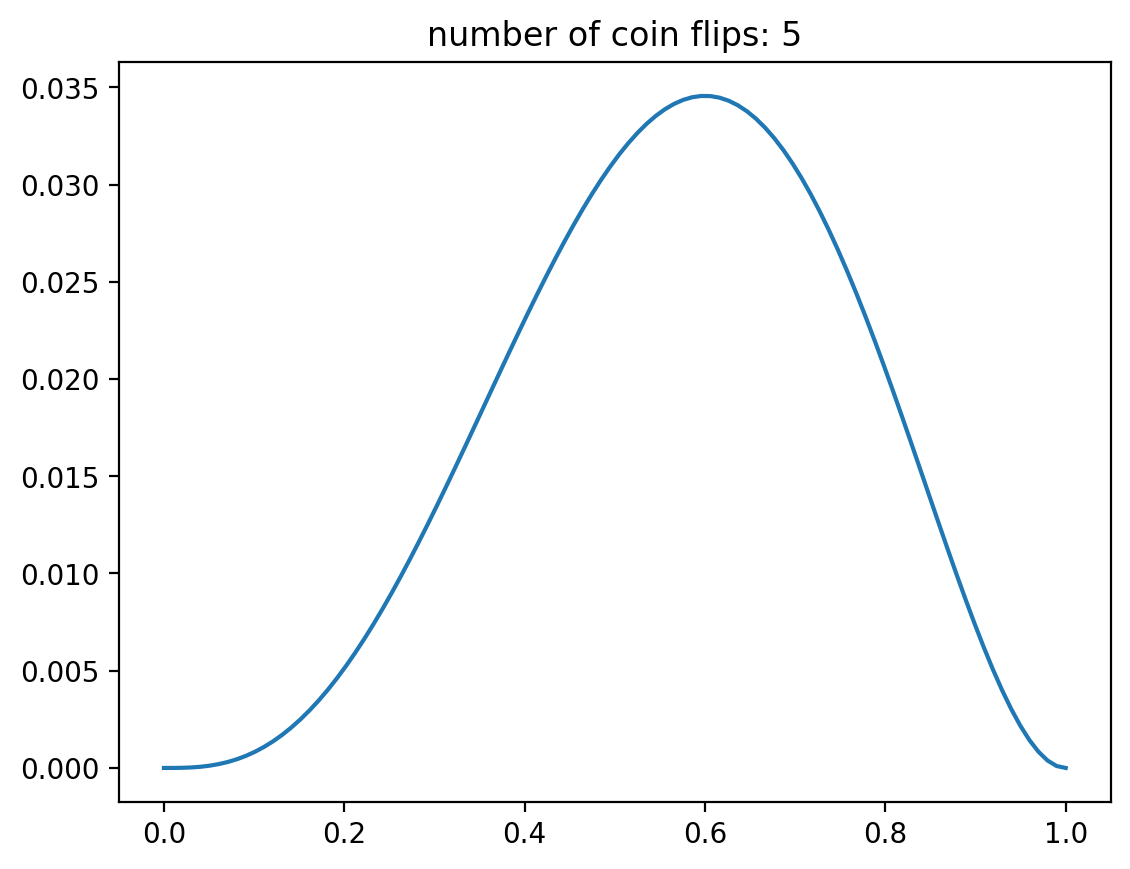

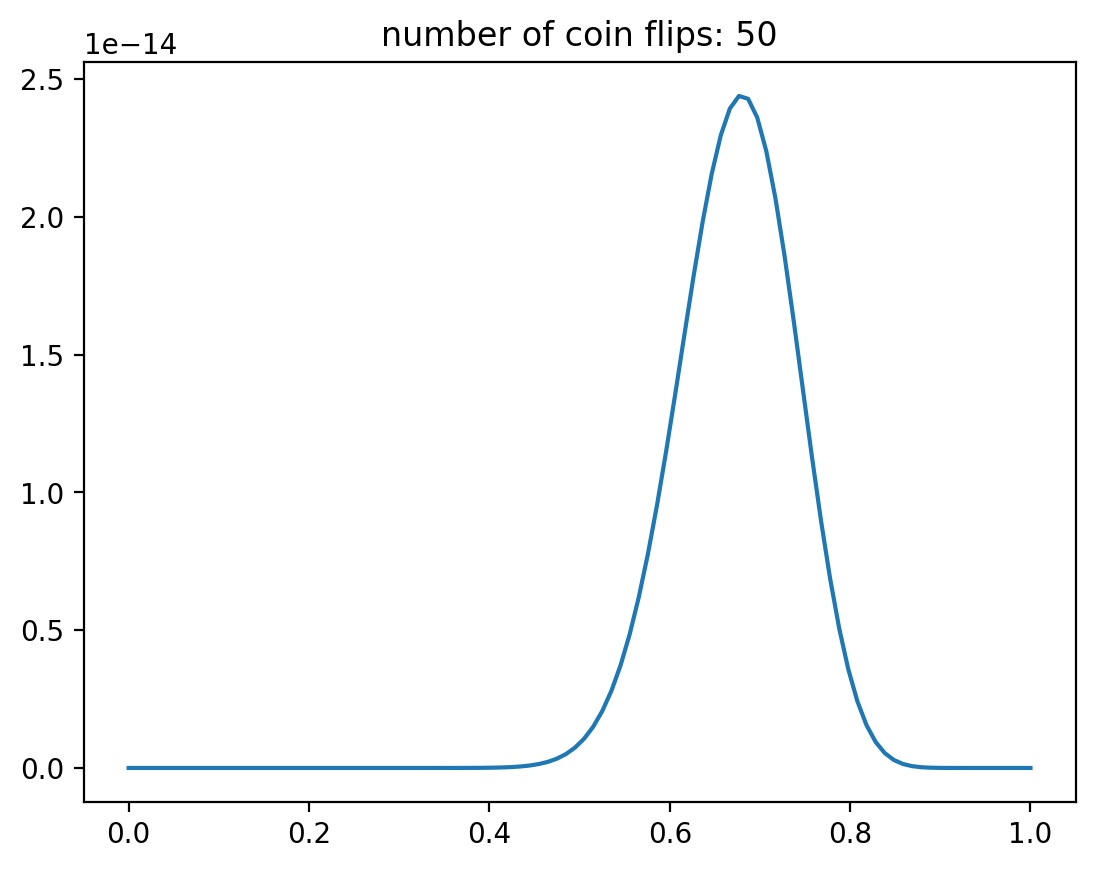

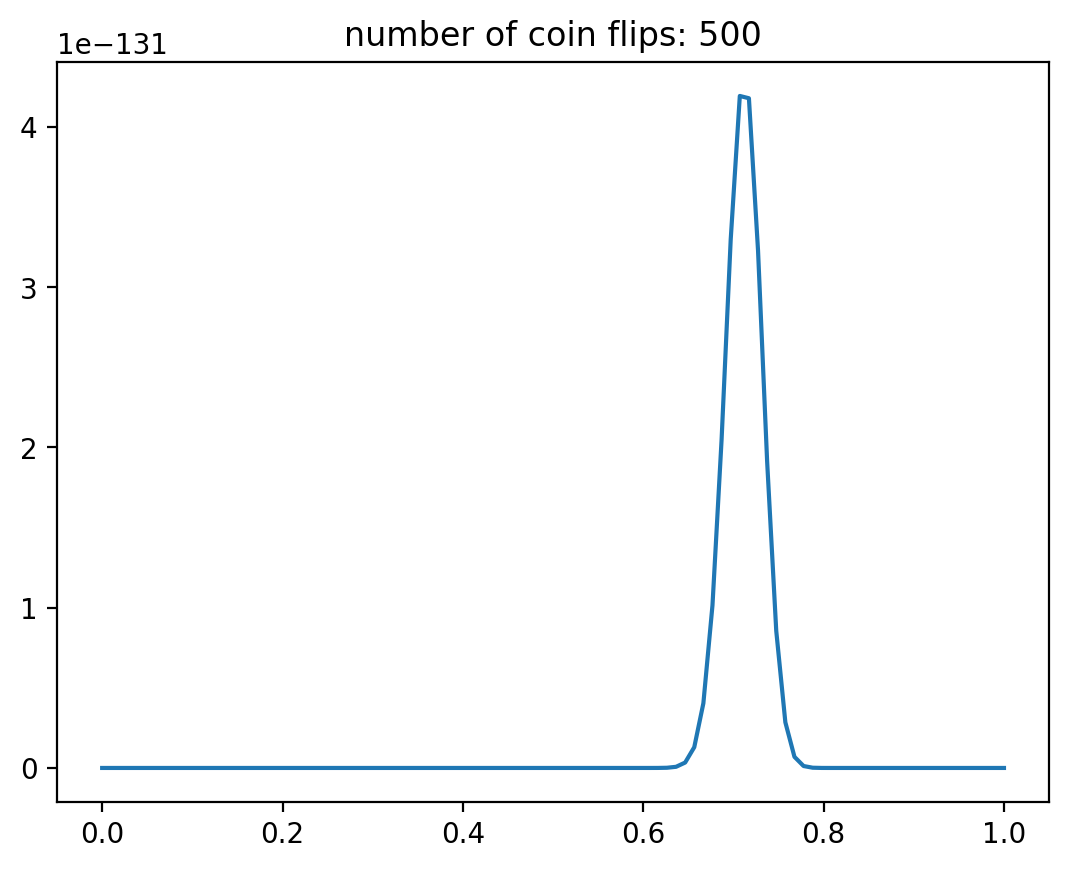

In [17]:
# Probability of getting h heads in n trials, given theta
def p_nheads(n, h, theta):
    return (theta**h) * ((1-theta)**(n-h))

# Likelihood function
def L(data, ntrials, theta):
    nheads = data[:ntrials].sum()
    return p_nheads(ntrials, nheads, theta)

# Prior. Just uniform?
def prior(theta):
    return 1

probs = []
# Define the number of trials
n_trials = [5, 50, 500]
theta = np.linspace(0, 1, 100)
for nt in n_trials:
    prob = L(data, nt, theta) * prior(theta)
    # posterior plot
    plt.plot(theta, prob, 
            label=r'ntrial = '+str(nt))
    # likelihood plot
    #plt.plot(theta, L(data, nt, theta))
    plt.title("number of coin flips: "+str(nt))  
    plt.show()


Careful that we're not tracking the normalization! But that's ok. We can trivially normalize the curve if we need it (most times we don't...)

Say you know this gambler already. What if I used a $\beta$ function for the prior?

$P(\alpha, \beta, \theta) = \theta^{\alpha-1} (1-\theta)^{(\beta-1)}$

Let's use a $\beta$ function prior on $\theta$ with $a=1$ and $b=10$. You can code this directly or grab from `scipy.stats`.

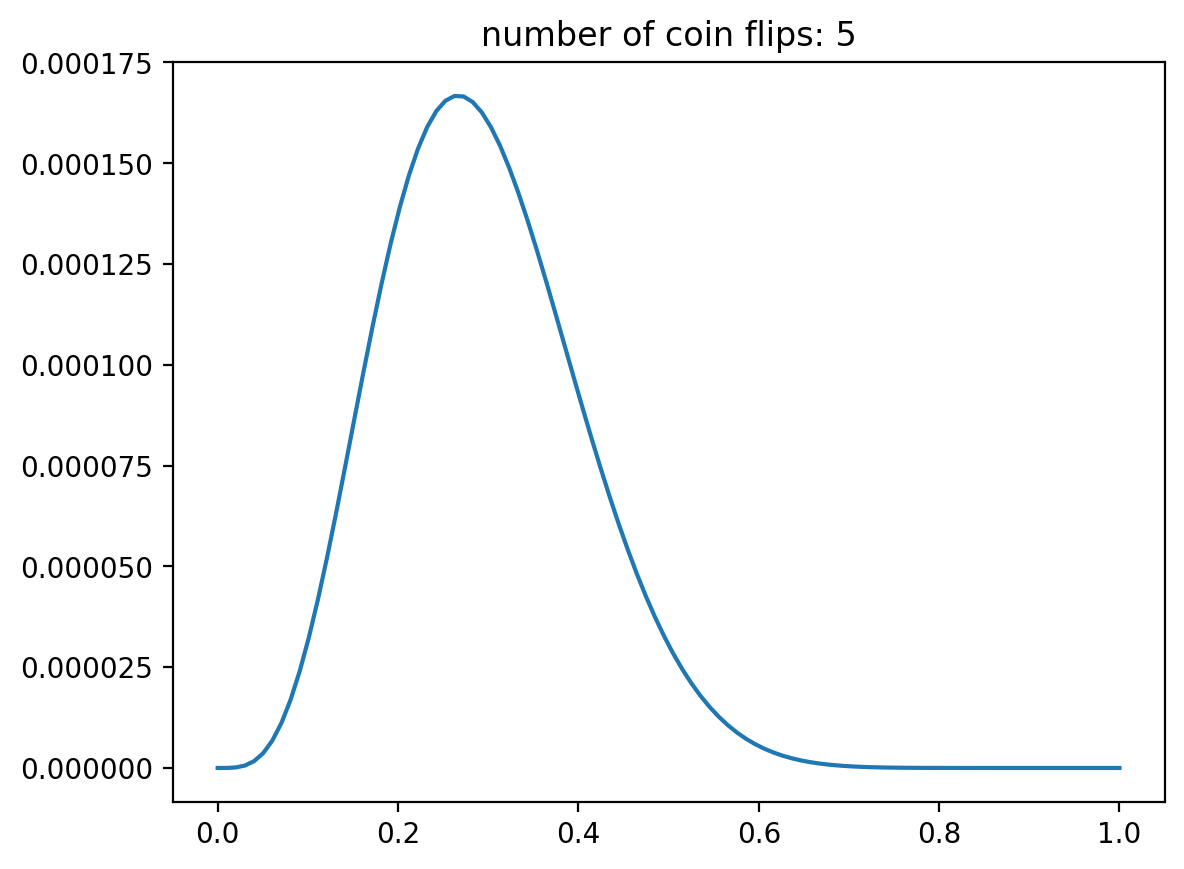

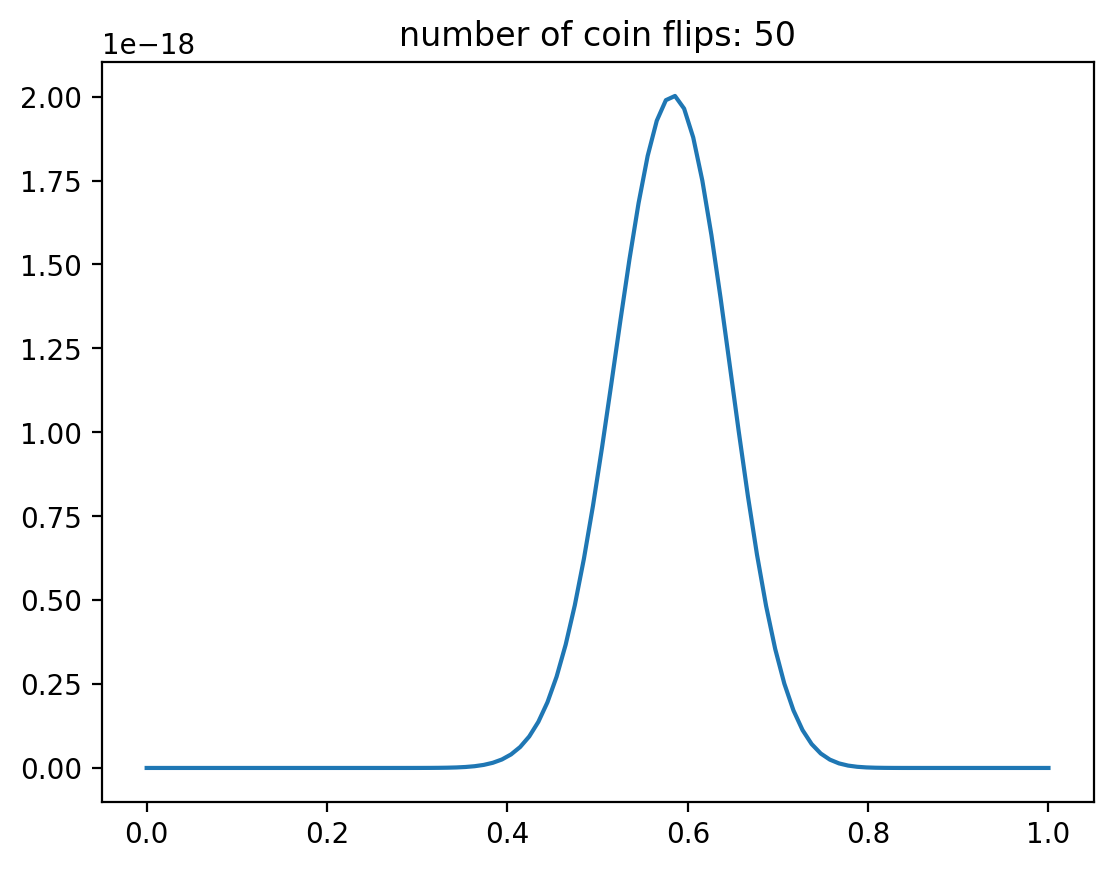

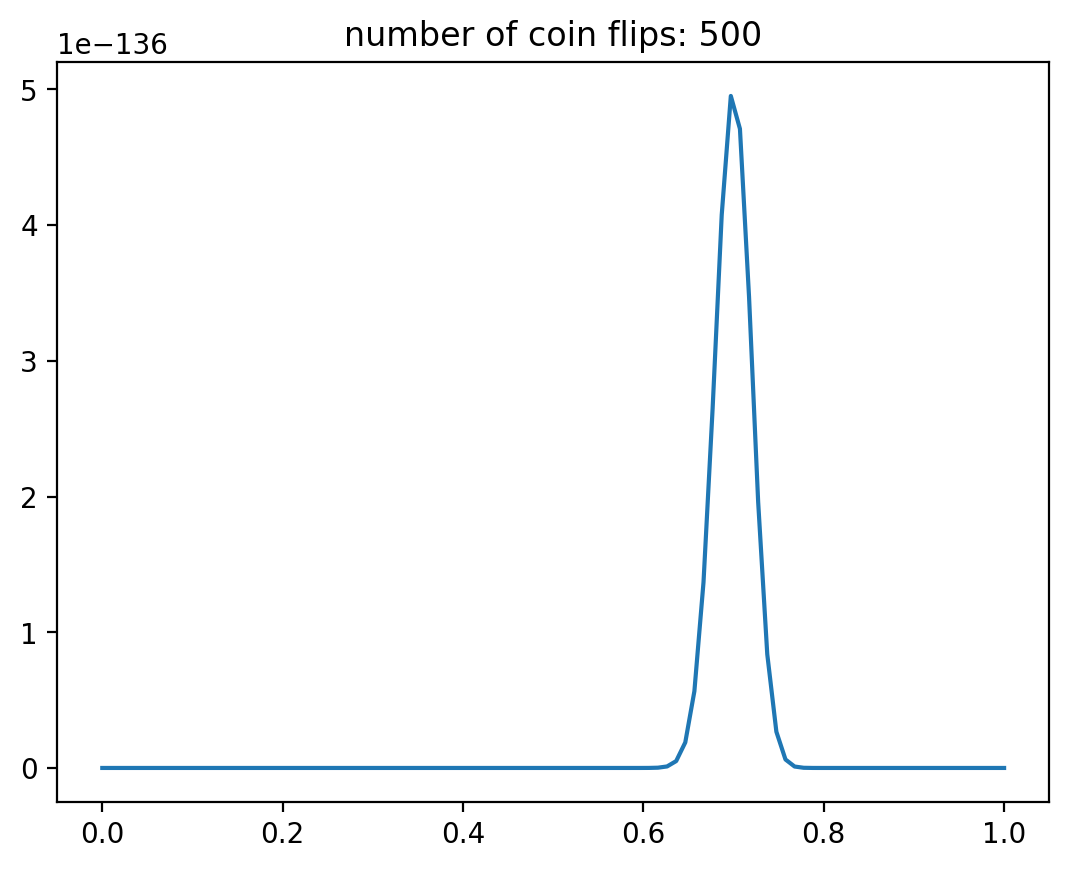

In [18]:
# Modify and execute this cell.

def p_nheads(n, h, theta):
    return (theta**h) * ((1-theta)**(n-h))

# likelihood
def L(data, ntrials, theta):
    nheads = data[:ntrials].sum()
    return p_nheads(ntrials, nheads, theta)

def prior(theta):
    alpha=1
    beta=10
    return  (theta**alpha) * ((1-theta)**(beta-1))

probs = []
# define the number of trials
n_trials = [5, 50, 500]
theta = np.linspace(0, 1, 100)
for nt in n_trials:
    prob = L(data, nt, theta) * prior(theta)
    # posterior plot
    plt.plot(theta, prob, 
            label=r'ntrial = '+str(nt))
    # likelihood plot
    #plt.plot(theta, L(data, nt, theta))
    plt.title("number of coin flips: "+str(nt))  
    plt.show()

The first case is different, the last one is not. As the amount of data increases, inference becomes data driven and the chosen prior is less important. Often we don't have this luxury! 

This is a simple but very important example. Initially, the result is prior driven, i.e. with low sample numbers, the posterior is leaning heavily towards your prior assumption. As you considered the larger data set, the influence of your prior fades.  

### Nuisance parameters and marginalization

#### Heteroscedastic Gaussian as an example


Consider the case of repeatedly measuring the mass of a particle
(e.g. a resonance peak in an invariant-mass spectrum),
assuming that the detector response is well understood.

We want to infer the posterior probability density for the true mass $\mu$,
given a set of measurements $\{x_i\}$ with known uncertainties $\{\sigma_i\}$:

$$
p(\mu \mid \{x_i\}, \{\sigma_i\}, I).
$$

Here:
- $x_i$ are individual mass measurements (for example from repeated events),
- $\sigma_i$ are the corresponding measurement uncertainties,
- and we assume the $\sigma_i$ are known and not inferred from the data.
For the likelihood we have

$$L = p(\{x_i\}|\mu,I) = \prod_{i=1}^N \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}
{2\sigma_i^2}\right).$$

---

**In the Bayesian case, we also need a prior.**  We'll adopt a *flat uniform distribution* given by

$$p(\mu|I) = C, \; {\rm for} \; \mu_{\rm min} < \mu < \mu_{\rm max},$$

where $C = \frac{1}{\mu_{\rm max} - \mu_{\rm min}}$ between the min and max and is $0$ otherwise.

The log of the posterior pdf is then

$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

This is exactly the same as we saw before, except that the value of the constant is different.  Since the constant doesn't come into play, we get the same result as before:
 
$$\mu^0 = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

with uncertainty

$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$
 
We get the same result because we used a flat prior. If the case were homoscedastic instead of heteroscedastic, we obviously would get the result from our first example.

---

Now let us consider the case where the measurement uncertainty $\sigma$
is not known a priori, but must be inferred from the data as well.

This situation arises naturally in particle physics.
For example, when measuring the mass of a particle from reconstructed events,
the detector resolution may not be perfectly characterized.
Changes in detector conditions, imperfect calibration,
or unmodeled effects can modify the width of the reconstructed mass distribution.

In this case, we want to use the data to infer **both**:
- the true particle mass $\mu$, and
- the effective detector resolution $\sigma$.

However, the detector resolution is not of intrinsic physical interest here.
It acts as a **nuisance parameter**.
Our primary goal is to infer $\mu$ as accurately as possible,
while correctly accounting for uncertainty in $\sigma$.

In this case, the posterior pdf that we seek is not $p(\mu|\{x_i\},\{\sigma_i\},I)$, but rather the joint $2$D pdf $p(\mu,\sigma|\{x_i\},I)$.

As before we have

$$L = p(\{x_i\}|\mu,\sigma,I) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right),$$

except that now $\sigma$ is uknown.

---


In the previous example, the measurement uncertainty $\sigma$ was assumed to be
known. We now relax this assumption and infer **both** the mean $\mu$ and the
standard deviation $\sigma$ from the data.

Since there are now two unknown parameters, the prior distribution must be
**two-dimensional**:

$$
p(\mu,\sigma \mid I).
$$



We adopt the joint prior

$$
p(\mu,\sigma\mid I) \propto \frac{1}{\sigma},
\qquad
\mu_{\min}<\mu<\mu_{\max},\;
\sigma_{\min}<\sigma<\sigma_{\max}.
$$

This choice has a clear interpretation:

- the prior on $\mu$ is uniform, expressing no preference for any particular value;
- the prior on $\sigma$ is proportional to $1/\sigma$, which corresponds to a
  uniform prior on $\ln\sigma$ (a scale-invariant or Jeffreys prior).


The Gaussian likelihood for $N$ independent measurements is

$$
p(\{x_i\}\mid\mu,\sigma,I)
=
\prod_{i=1}^N
\frac{1}{\sigma\sqrt{2\pi}}
\exp\left[
-\frac{(x_i-\mu)^2}{2\sigma^2}
\right].
$$

Each data point contributes a factor $1/\sigma$, so the likelihood contains a
factor $\sigma^{-N}$. Multiplying by the prior $p(\mu,\sigma)\propto 1/\sigma$
gives an overall factor

$$
\sigma^{-(N+1)}.
$$

With proper normalization, the unnormalized posterior is therefore

$$
p(\{x_i\}\mid\mu,\sigma,I)\,p(\mu,\sigma\mid I)
=
C\,\frac{1}{\sigma^{N+1}}
\prod_{i=1}^N
\exp\left[
-\frac{(x_i-\mu)^2}{2\sigma^2}
\right],
$$

where the constant $C$ depends only on fixed bounds and $N$ and does not depend
on $\mu$ or $\sigma$.



Taking the logarithm, we obtain

$$
\ln p(\mu,\sigma\mid\{x_i\},I)
=
\text{constant}
-
(N+1)\ln\sigma
-
\sum_{i=1}^N
\frac{(x_i-\mu)^2}{2\sigma^2}.
$$

The three terms arise from:
- the Gaussian likelihood,
- the $1/\sigma$ prior,
- and normalization constants.



For Gaussian data, the following identity holds:

$$
\sum_{i=1}^N (x_i-\mu)^2
=
N(\bar{x}-\mu)^2
+
\sum_{i=1}^N (x_i-\bar{x})^2.
$$

Define:
- the sample mean
$$
\bar{x} = \frac{1}{N}\sum_{i=1}^N x_i,
$$
- the sample variance
$$
V = \frac{1}{N}\sum_{i=1}^N (x_i-\bar{x})^2.
$$

Using these definitions, the log-posterior becomes

$$
\ln p(\mu,\sigma\mid\{x_i\},I)
=
\text{constant}
-
(N+1)\ln\sigma
-
\frac{N}{2\sigma^2}
\left[
(\bar{x}-\mu)^2 + V
\right].
$$


The posterior depends on the full dataset $\{x_i\}$ **only** through the three
quantities

$$
(N,\;\bar{x},\;V).
$$

These quantities are called **sufficient statistics**: once they are known,
the individual data points contain no additional information about $\mu$ and
$\sigma$.

This is why the posterior can be visualized and explored using only these three
numbers, without reference to the original measurements.

The code below visualizes the posterior pdf for the case of $(N,\overline{x},V)=(10,1,4)$. Play around with it  changing the values of $(N,\overline{x},V)$.</font> 

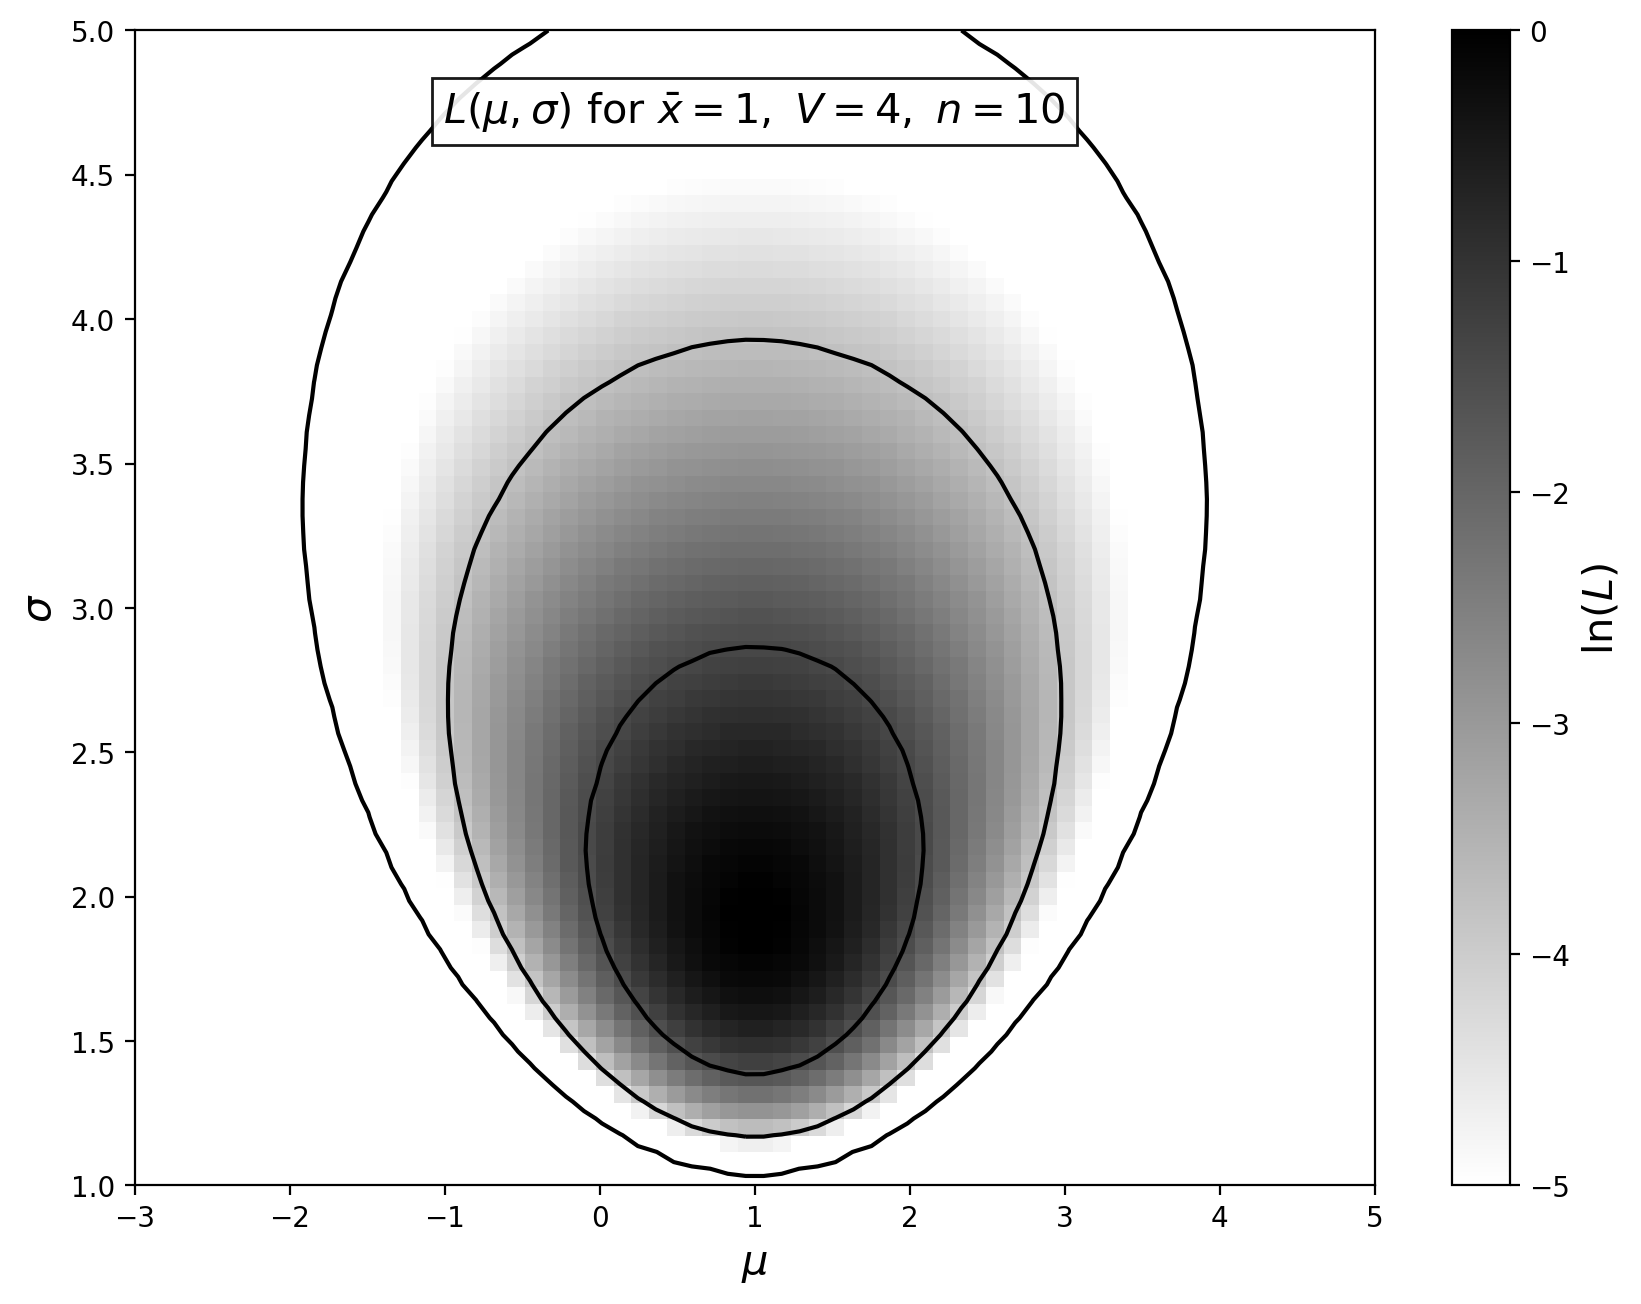

In [18]:
# %load code/fig_likelihood_gaussian.py
"""
Log-likelihood for Gaussian Distribution
----------------------------------------
Figure5.4
An illustration of the logarithm of the posterior probability density
function for :math:`\mu` and :math:`\sigma`, :math:`L_p(\mu,\sigma)`
(see eq. 5.58) for data drawn from a Gaussian distribution and N = 10, x = 1,
and V = 4. The maximum of :math:`L_p` is renormalized to 0, and color coded as
shown in the legend. The maximum value of :math:`L_p` is at :math:`\mu_0 = 1.0`
and :math:`\sigma_0 = 1.8`. The contours enclose the regions that contain
0.683, 0.955, and 0.997 of the cumulativexw (integrated) posterior probability.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
#from astroML.plotting.mcmc import convert_to_stdev

import numpy as np

#In the astroML library, but redefined here for completeness because it does not work with the current version of astroML (and this will work in google colab)
def convert_to_stdev(logp):  
    """
    Convert a log-posterior grid into cumulative probability content,
    suitable for contour plotting.
    """
    p = np.exp(logp - logp.max())
    p /= p.sum()

    p_flat = p.ravel()
    idx = np.argsort(p_flat)[::-1]

    cdf = np.cumsum(p_flat[idx])

    # Allocate output array
    cdf_grid = np.empty_like(p_flat)
    cdf_grid[idx] = cdf

    return cdf_grid.reshape(p.shape)


def gauss_logL(xbar, V, n, sigma, mu):
    """Equation 5.57: gaussian likelihood"""
    return (-(n + 1) * np.log(sigma)
            - 0.5 * n * ((xbar - mu) ** 2 + V) / sigma ** 2)

#------------------------------------------------------------
# Define the grid and compute logL
sigma = np.linspace(1, 5, 70)
mu = np.linspace(-3, 5, 70)
xbar = 1
V = 4
n = 10

logL = gauss_logL(xbar, V, n, sigma[:, np.newaxis], mu)
logL -= logL.max()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 7.5))
plt.imshow(logL, origin='lower',
           extent=(mu[0], mu[-1], sigma[0], sigma[-1]),
           cmap=plt.cm.binary,
           aspect='auto')
plt.colorbar().set_label(r'$\ln(L)$', fontsize=15)
plt.clim(-5, 0)

plt.contour(mu, sigma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='k')

plt.text(0.5, 0.93, r'$L(\mu,\sigma)\ \mathrm{for}\ \bar{x}=1,\ V=4,\ n=10$',
         bbox=dict(ec='k', fc='w', alpha=0.9),
         ha='center', va='center', 
         fontsize=15, transform=plt.gca().transAxes)

plt.xlabel(r'$\mu$', fontsize=15)
plt.ylabel(r'$\sigma$', fontsize=15)

plt.show()

The plot from the previous cell is described by 

$$\ln[p(\mu,\sigma|\{x_i\},I)] = {\rm constant} - (N+1)\ln\sigma - \frac{N}{2\sigma^2}\left( (\overline{x}-\mu)^2 + V  \right).$$


**What if we don't care that much about $\sigma$?** e.g. it may simply represent how good our measuring apparatus is—what we might get a Nobel prize for is $\mu$ (the mass of a new particle!).
- Therefore, what we want is $p(\mu|\{x_i\},I)$, rather than $p(\mu,\sigma|\{x_i\},I)$. 
- We can get the former from the latter by the **marginalization over $\sigma$**, which means integration of $p(\mu,\sigma|\{x_i\},I)$ over $\sigma$: 

$$ p(\mu\,|\,\{x_i\},I) = \int_0^\infty p(\mu,\sigma|\{x_i\},I) d\sigma$$
and thus (using the substitution $t$ = 1/$\sigma$ and integration by parts)

$$ p(\mu\,|\,\{x_i\},I) \propto \left(1 + \frac{(\overline{x}-\mu)^2}{V} \right)^{-N/2}. $$

It is easy to show that this result corresponds to *Student’s $t$ distribution* (this is a nice proof, Google it!) with 
$k = N-1$ degrees of freedom for the variable $t = (x-\mu)/(s/\sqrt{N})$, where $s$ is the sample 
standard deviation. As we've seen the Student’s $t$ distribution is symmetric and bell shaped, but with heavier 
tails than  a Gaussian distribution.  

**Hold on!** This is not a Gaussian distribution promised by the Central Limit Theorem!!! 

That's fine! The CLT promised a Gaussian only for large $N$. Indeed, the above expression
(Student's $t$ distribution) morphs into a Gaussian for large $N$ - let's check!


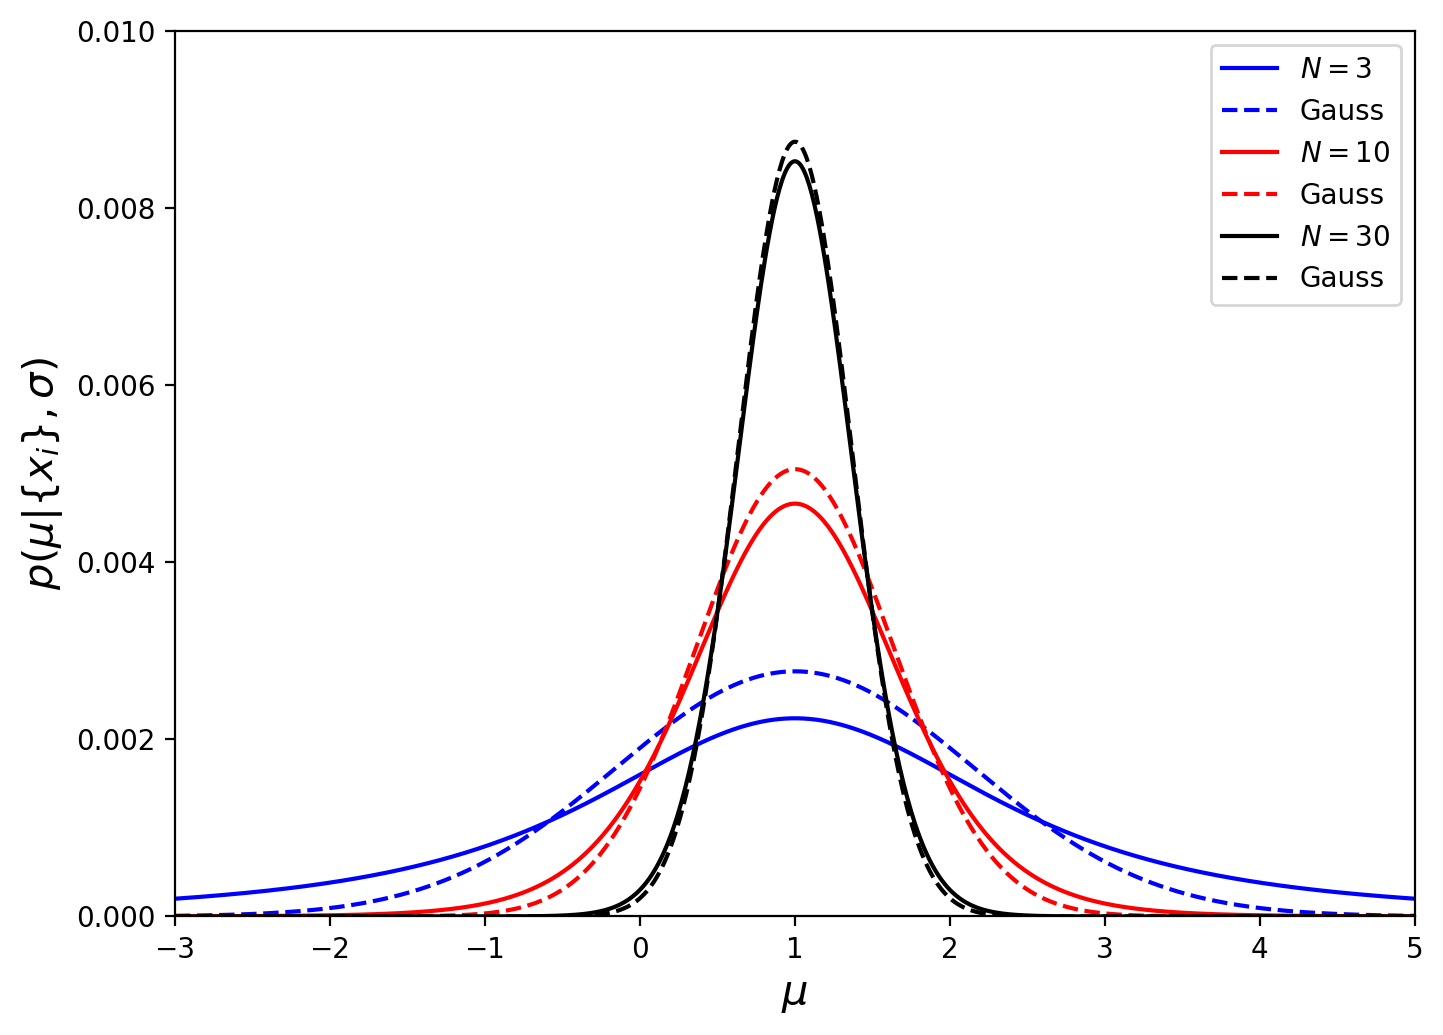

In [19]:
### Let's see how Student's t distribution morphs into Gaussian distribution
# Let's first choose mean x and variance as in the previous example
mu = np.linspace(-3, 5, 1000)
xbar = 1.0
V = 4.0

# and now let's generate p(mu) for N=3, 10 and 20
def compute_pmu(mu, xbar, V, N):
    p = (1 + (xbar - mu) ** 2 / V) ** (-0.5 * N) # Student's t distribution
    return p / np.sum(p) # normalize

N1 = 3
pmu1 = compute_pmu(mu,xbar,V,N1)
G1 = norm(xbar, np.sqrt(V/N1)).pdf(mu) 
G1norm = G1 / np.sum(G1)

N2 = 10
pmu2 = compute_pmu(mu,xbar,V,N2)
G2 = norm(xbar, np.sqrt(V/N2)).pdf(mu) 
G2norm = G2 / np.sum(G2)

N3 = 30
pmu3 = compute_pmu(mu,xbar,V,N3)
G3 = norm(xbar, np.sqrt(V/N3)).pdf(mu) 
G3norm = G3 / np.sum(G3)
 
# Plot
fig, ax = plt.subplots(figsize=(8, 5.75))
plt.plot(mu, pmu1, ls='-', c='blue', label=r'$N=3$')
plt.plot(mu, G1norm, ls='--', c='blue', label=r'Gauss')
plt.plot(mu, pmu2, ls='-', c='red', label=r'$N=10$')
plt.plot(mu, G2norm, ls='--', c='red', label=r'Gauss')
plt.plot(mu, pmu3, ls='-', c='black', label=r'$N=30$')
plt.plot(mu, G3norm, ls='--', c='black', label=r'Gauss')

plt.xlim(-3, 5)
plt.ylim(0, 0.01)
plt.xlabel('$\mu$', fontsize=15)
plt.ylabel(r'$p(\mu | \{x_i\},\sigma)$', fontsize=15)
plt.legend()
plt.show() 

- The main result here is that **for smallish N (<10 or so), $p(\mu)$ is not Gaussian!** 
- The code above can be used to compute $p(\mu)$ for arbitrary values of N, $\overline{x}$ and V.
- For large N, Gaussian is a good approximation of $p(\mu)$. 

The top panels of the figure below (textbook figure 5.5, for the code see the 
[astroML website](http://www.astroml.org/book_figures/chapter5/fig_posterior_gaussian.html)) show marginal distributions $p(\mu)$ and $p(\sigma)$ for $(N,\overline{x},V)=(10,1,4)$.

- Blue solid line is the analytic Bayesian result with uninformative prior, i.e. $p(\sigma)\propto 1/\sigma$
- Red dotted line is the result for a uniform prior (note that there is not that much difference).
- Red dashed line is the analytic MLE result, which is quite different!
- Circles indicate the distributions of bootstrap estimates.

The bottom panels show the cumulative distributions.

![Ivezic, Figure 5.5](http://www.astroml.org/_images/fig_posterior_gaussian_1.png)
 

The figure compares different ways of quantifying uncertainty in the mean $\mu$ and standard deviation $\sigma$ of a Gaussian distribution for the same dataset $(N,\bar{x},V)=(10,1,4)$. The blue solid curves show the fully Bayesian marginal posteriors obtained by integrating the joint posterior $p(\mu,\sigma\mid D)$ and adopting a weakly informative, scale-invariant prior $p(\sigma)\propto 1/\sigma$. The red dotted curves correspond to a Bayesian analysis with a uniform prior on $\sigma$, illustrating that reasonable prior choices lead to similar—but not identical—results when the data are limited. The red dashed curves show the frequentist maximum-likelihood (MLE) approximation, which treats the estimates as approximately Gaussian and tends to underestimate the uncertainty in $\sigma$ for small samples. The circles indicate the distributions of bootstrap estimates, obtained by repeatedly resampling the data and refitting, which provide a frequentist, data-driven measure of estimator variability. The bottom panels display the corresponding cumulative distributions, highlighting how small differences in the PDFs translate into different credible or confidence intervals. Overall, the figure emphasizes that for small datasets, Bayesian posteriors, MLE approximations, and bootstrap estimates can differ substantially—especially for variance-like parameters—while they converge as the sample size increases.

### Bayesian vs Frequentist perspectives

This comparison highlights the conceptual difference between **Bayesian** and
**frequentist** approaches to inference. In the Bayesian framework, probability
quantifies a *degree of belief*: the posterior distributions shown in the figure
represent our uncertainty about the true values of $\mu$ and $\sigma$ after
combining the data with prior assumptions. Credible intervals derived from these
posteriors can be interpreted directly as probability statements about the
parameters themselves.

In contrast, frequentist methods do not assign probabilities to parameters.
The maximum-likelihood estimate provides a single best-fit value, and its
associated uncertainty is derived from the sampling distribution of the
estimator under repeated hypothetical experiments. Bootstrap distributions are
also frequentist in spirit: they approximate how an estimator would fluctuate
if the experiment were repeated many times, but they do not represent a
probability distribution for the parameter in a single experiment.

The figure shows that these approaches can give noticeably different answers
when the dataset is small, particularly for nuisance or scale parameters such as
$\sigma$. None of the methods is “wrong”; they answer different questions. As
the number of data points increases, the influence of the prior diminishes and
the Bayesian posterior, the MLE approximation, and bootstrap estimates tend to
converge, reflecting the fact that sufficiently informative data overwhelm
methodological differences.